# Multivariate Bayesian last layer for a toy example

In [1]:
# Choose TRUE or FALSE whether to export figures
export_figures = False
export_dir = '../Plots/MultivariateToyExample/'

from pathlib import Path
Path(export_dir).mkdir(parents=True, exist_ok=True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import pdb
import sys
import pickle

# Matplotlib configuration
# execfile('../Plots/config_mpl.py')
import matplotlib as mpl
color = mpl.rcParams['axes.prop_cycle'].by_key()['color']
sys.path.append('../bll_pytorch/')

import torch
import torch.nn as nn
import bayesianlastlayer as bll
from torch_model import JointModel
import tools
import bayli 
importlib.reload(bll)
importlib.reload(tools)
importlib.reload(bayli)


<module 'bayli' from '/home/nils/Documents/2023_Paper_BLL_LML/Pytorch results/../bll_pytorch/bayli.py'>

Initiate dictionary to store results for Table 1 in paper.

In [3]:
result_dict = {
    'LML feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    'MAP feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    }

# Generate (multivariate) data

The data has two outputs ($n_y=2$) and one inputs ($n_x=1$). 
Both outputs have different magnitudes for the noise.

Four datasets are created:
- ``train``
- ``test``
- ``validation``
- ``true``

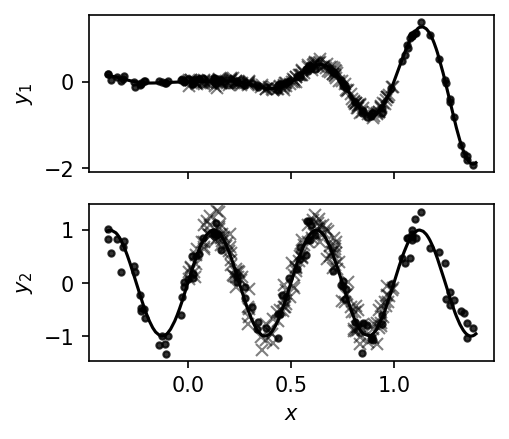

In [4]:
n_samples = 200
seed = 99

function_types = [1, 3]
sigma_noise = [5e-2, 2e-1]
n_channels = len(function_types)

train = tools.get_data(n_samples,[0,1], function_type=function_types, sigma=sigma_noise, dtype='float32', random_seed=seed)
test= tools.get_data(100, [-.4,1.4],   function_type=function_types, sigma=sigma_noise, dtype='float32', random_seed=seed)
true = tools.get_data(300, [-.4,1.4],  function_type=function_types, sigma=[0.,0.], dtype='float32')

train, val = tools.split(train, test_size=0.2)

# Create scaler from training data
scaler  = tools.Scaler(*train)

# Scale data (only required for testing purposes)
train_scaled = scaler.scale(*train)
val_scaled = scaler.scale(*val)
test_scaled = scaler.scale(*test)
true_scaled = scaler.scale(*true)



def get_figure(n_channels=n_channels):
    # Plot data
    fig, ax = plt.subplots(n_channels, 1, figsize=(3.49, 3.0),dpi=150, sharex=True)

    if n_channels == 1:
        ax = [ax]

    for i in range(n_channels):
        ax[i].plot(true[0], true[1][:,i], label='true', color='k')
        ax[i].plot(train[0], train[1][:,i], 'x', color='k', label=f'train', alpha=0.5)
        ax[i].plot(test[0], test[1][:,i], '.', color='k', label=f'test', alpha=0.8)

    ax[0].set_ylabel('$y_1$')
    ax[1].set_ylabel('$y_2$')
    ax[-1].set_xlabel('$x$')

    return fig, ax

fig, ax = get_figure()

# Torch model with Bayesian last layer
Generate a keras model and initialize a ``BayesianLastLayer`` instance.

In [5]:
# Fix seeds
def get_model():
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Hidden units
    n_hidden = 20
    n_in = 1
    n_out = n_channels
    architecture = [
        (nn.Linear, {'in_features': n_in, 'out_features': n_hidden, 'bias': True}),
        (nn.Tanh, {}),
        (nn.Linear, {'in_features': n_hidden, 'out_features': n_hidden, 'bias': True}),
        (nn.Tanh, {}),
        (nn.Linear, {'in_features': n_hidden, 'out_features': n_hidden, 'bias': True}),
        (nn.Tanh, {}),
        (nn.Linear, {'in_features': n_hidden, 'out_features': n_out, 'bias': True}),
    ]

    # Get layers and outputs:
    joint_model = JointModel(architecture)

    return joint_model

## Train the model with log-marginal-likelihood loss
Use Keras callbacks for early stopping


In [6]:
# Load model or create and train new model
save_name_bll = 'results/02_Multivariate_BLLModel01.pkl'
load_saved_model = False

if not load_saved_model:
    # Fix seeds
    np.random.seed(seed)
    torch.manual_seed(seed)

    joint_model = get_model()
    # Get bll model
    bllmodel = bll.BayesianLastLayer(joint_model, scaler)
    #Prepare training
    optimizer = torch.optim.Adam
    #Setup training:
    bllmodel.setup_training(optimizer, optimizer_kwargs={'lr':1e-3})
    # Get callback for early stopping

    #Train
    bllmodel.fit(*train, val=val, epochs=10000, verbose=True)

    # bllmodel.save(save_name_bll, custom_objects={'sin': tf.math.sin})
else:
    # Unpickle
    with open(save_name_bll, 'rb') as f:
        bllmodel = pickle.load(f)

    joint_model = bllmodel.joint_model


Print information about trained bllmodel

In [7]:
print(bllmodel)

BayesianLastLayer
----------------
State:
- setup_training = True
- prepare_prediction = True
- n_x   = 1
- n_phi = 21
- n_y   = 2
Results:
- train_lml   = [-0.341]
- log_alpha   = [2.447]
- log_sigma_e = [-1.893 -1.428]



In [8]:
print(f'Noise sigma on data: {np.array(sigma_noise)}')
print(f'Estimated noise sigma: {torch.exp(bllmodel.log_sigma_e).detach().numpy()*bllmodel.scaler.scaler_y.std.numpy()}')

Noise sigma on data: [0.05 0.2 ]
Estimated noise sigma: [[0.04558346 0.16851717]]


Save scores for BLL:

In [9]:
%%capture

result_dict['LML feat']['LML']['alpha_star'].update({
'train': bllmodel.score(*train, scoring='lml'),
'test': bllmodel.score(*test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_star'].update({
'train': bllmodel.score(*train, scoring='lpd'),
'test': bllmodel.score(*test, scoring='lpd'),
})
result_dict['LML feat']['MSE'][' '].update({
'train': bllmodel.score(*train, scoring='mse'),
'test': bllmodel.score(*test, scoring='mse'),
})

## Test for better values of $\alpha$ and reset parameter

In [10]:
bll_log_alpha_test = bllmodel.grid_search_alpha(*test, rel_range=[-3,10], scores=['lml', 'lpd'], samples = 200, max_cond=1e8)
bll_log_alpha_train = bllmodel.grid_search_alpha(*train, rel_range=[-3,10],scores=['lml', 'lpd'], samples = 200, max_cond=1e8)

ind_alpha_max_bll = np.argmax(bll_log_alpha_test['lpd'])
alpha_max_bll = bll_log_alpha_test['log_alpha'][ind_alpha_max_bll]
alpha_opt_bll = bllmodel.log_alpha.detach().numpy()

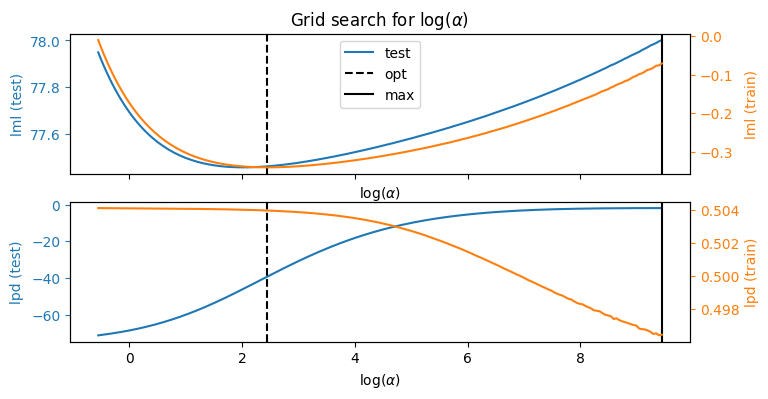

In [11]:

fig, ax = tools.plot_alpha_search(bll_log_alpha_train, bll_log_alpha_test, alpha_opt_bll, alpha_max_bll, figsize=(8,4), sharex=True)
fig.align_ylabels()

### Reset alpha and obtain updated KPI

In [12]:
bllmodel.log_alpha = alpha_max_bll

In [13]:
%%capture 

result_dict['LML feat']['LML']['alpha_max'].update({
    'train': bllmodel.score(*train, scoring='lml'),
    'test': bllmodel.score(*test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_max'].update({
    'train': bllmodel.score(*train, scoring='lpd'),
    'test': bllmodel.score(*test, scoring='lpd'),
})

### Predictive distribution for updated alpha in comparison with previous results

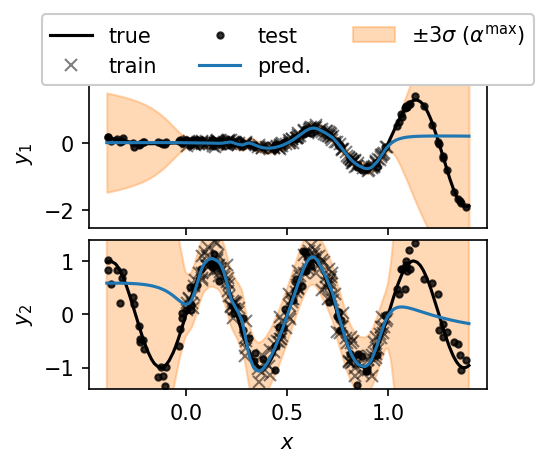

In [14]:
# Create prediction
y_pred, y_std_alpha_max = bllmodel.predict(true[0], uncert_type='std', with_noise_variance=True)

y_pred = y_pred.detach().numpy()
y_std_alpha_max = y_std_alpha_max.detach().numpy()
# Plus/minus 3 sigma:
p3sigma_alpha_max = (y_pred+3*y_std_alpha_max)
m3sigma_alpha_max = (y_pred-3*y_std_alpha_max)

# Get figure:
fig, ax = get_figure()

# Add to figure:
for i in range(n_channels):
    ax[i].plot(true[0], y_pred[:,i], '-', color=color[0], label='pred.')
    #ax[i].fill_between(true[0].flatten(), m3sigma_alpha_star[:,i], p3sigma_alpha_star[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^*)$', color=color[0])
    ax[i].fill_between(true[0].flatten(), m3sigma_alpha_max[:,i], p3sigma_alpha_max[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^{\text{max}})$', color=color[1])

    data_min = np.min(true[1][:,i].detach().numpy())
    data_max = np.max(true[1][:,i].detach().numpy())
    data_range = data_max - data_min
    ax[i].set_ylim(data_min - .2*data_range, data_max + .2*data_range)

fig.align_ylabels()
legend = ax[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(.5, 1.5), fancybox=True, framealpha=1)
fig.tight_layout(pad=0.2)

if export_figures:
    name = '07_Multivariate_LMLH.pgf'
    fig.savefig(f'{export_dir}{name}')